In [1]:
import os.path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

In [2]:
# initial computation of database entry counts to achieve desired sizes
key_size = 16
value_sizes = [16, 256, 4096]
db_sizes_gb = [10, 50, 250]
gb = 1000 ** 3
entry_overhead = 4 # approximate


db_specs = pd.DataFrame([dict(value_size=vs, db_size=gb*ds)
                         for vs in value_sizes for ds in db_sizes_gb])
db_specs['entry_size'] = entry_overhead + key_size + db_specs['value_size']
db_specs['entries'] = db_specs['db_size'] / db_specs['entry_size']
db_specs

,value_size,db_size,entry_size,entries
0,16,10000000000,36,2.777778e+08
1,16,50000000000,36,1.388889e+09
2,16,250000000000,36,6.944444e+09
3,256,10000000000,276,3.623188e+07
4,256,50000000000,276,1.811594e+08
5,256,250000000000,276,9.057971e+08
6,4096,10000000000,4116,2.429543e+06
7,4096,50000000000,4116,1.214772e+07
8,4096,250000000000,4116,6.073858e+07


In [3]:
single_gb_file_specs = db_specs[db_specs['db_size'] == 10*gb].set_index('value_size')['entries'] / 10
single_gb_file_specs

value_size
16      2.777778e+07
256     3.623188e+06
4096    2.429543e+05
Name: entries, dtype: float64

In [4]:
figdir = 'figures/disk_key_value_readonly'
!mkdir -p $figdir

In [5]:
!ls ../benchmarks/disk_key_value/readonly/*

../benchmarks/disk_key_value/readonly/c5n.2xlarge_hdd_2020_04_16.jsonl
../benchmarks/disk_key_value/readonly/c5n.2xlarge_ssd_2020_04_16.jsonl
../benchmarks/disk_key_value/readonly/i3.2xlarge_2020_04_16.jsonl
../benchmarks/disk_key_value/readonly/local_2020_04_15.jsonl


In [6]:
duration_seconds = 10

def load_results(pathname, disk_name):
    results = []
    with open(f'../benchmarks/disk_key_value/readonly/{pathname}.jsonl', 'rt') as fp:
        for line in fp:
            spec, counts = json.loads(line)
            spec.update(counts)
            results.append(spec)
    results = pd.DataFrame(results)
    results['disk'] = disk_name
    
    results = results[results['seconds'] == duration_seconds]
    
    split_paths = results['data_path'].map(lambda x: x.split(os.path.sep))

    results['db_size'] = split_paths.map(lambda x: int(x[-2].replace('db', '')))
    results['value_size'] = split_paths.map(lambda x: int(x[-3].replace('vs_', '')))
    results['index'] = results['index_path'].map(os.path.basename)

    results = results.drop(['data_path', 'known_keys_data_path', 'key_set_size', 'index_path', 'seconds'], axis=1)
    return results

results = pd.concat([
    load_results('i3.2xlarge_2020_04_16', 'nvme'),
    load_results('c5n.2xlarge_ssd_2020_04_16', 'ssd'),
    load_results('c5n.2xlarge_hdd_2020_04_16', 'hdd')
])

results.sample(5)

,known_key_get_frac,read_threads,trial_index,get,found,disk,db_size,value_size,index
935,0.9,1,5,20749,18676,ssd,50,4096,index10
825,0.1,1,5,15778,1551,nvme,250,4096,index100
492,0.1,16,3,112697,11198,ssd,50,4096,index10
321,0.5,4,5,12142,6114,ssd,50,4096,index100
282,0.9,4,1,49026,44138,ssd,250,4096,index10


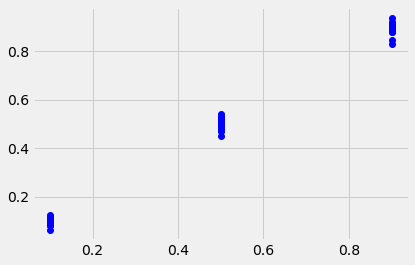

In [7]:
plt.plot(results['known_key_get_frac'], results['found'] / results['get'], 'bo')

In [8]:
x = results.copy()
x['get'] /= (duration_seconds * 1000)
agg = x.groupby(['disk', 'db_size', 'index', 'value_size', 'known_key_get_frac', 'read_threads'])['get'].describe()
agg = agg[['count', 'min', '25%', '50%', '75%', 'max']]
agg.sample(10)

count  \
disk db_size index     value_size known_key_get_frac read_threads          
hdd  50      index10   4096       0.1                4               1.0   
nvme 250     index100  4096       0.1                16             10.0   
                                                     1              10.0   
     10      index1000 4096       0.5                4              10.0   
ssd  10      index10   4096       0.5                16             10.0   
             index1000 4096       0.1                64             10.0   
     250     index1000 4096       0.9                16             10.0   
     10      index10   4096       0.9                4              10.0   
nvme 250     index1000 4096       0.1                64             10.0   
ssd  50      index10   4096       0.5                64             10.0   

                                                                       min  \
disk db_size index     value_size known_key_get_frac read_threads            
hdd  50      index10   4096       0.1                4              0.4436   
nvme 250     index100  4096       0.1                16            11.1796   
                                                     1              1.5248   
     10      index1000 4096       0.5                4              1.0450   
ssd  10      index10   4096       0.5                16            77.4448   
             index1000 4096       0.1                64             0.2774   
     250     index1000 4096       0.9                16             0.1390   
     10      index10   4096       0.9                4             52.0993   
nvme 250     index1000 4096       0.1                64             1.1343   
ssd  50      index10   4096       0.5                64             1.9023   

                                                                          25%  \
disk db_size index     value_size known_key_get_frac read_threads               
hdd  50      index10   4096       0.1                4               0.443600   
nvme 250     index100  4096       0.1                16             11.339800   
                                                     1               1.540625   
     10      index1000 4096       0.5                4               1.055725   
ssd  10      index10   4096       0.5                16            106.197475   
             index1000 4096       0.1                64              0.417075   
     250     index1000 4096       0.9                16              0.139150   
     10      index10   4096       0.9                4              79.250725   
nvme 250     index1000 4096       0.1                64              1.168050   
ssd  50      index10   4096       0.5                64              2.043125   

                                                                         50%  \
disk db_size index     value_size known_key_get_frac read_threads              
hdd  50      index10   4096       0.1                4               0.44360   
nvme 250     index100  4096       0.1                16             11.40735   
                                                     1               1.55880   
     10      index1000 4096       0.5                4               1.05825   
ssd  10      index10   4096       0.5                16            113.23915   
             index1000 4096       0.1                64              1.31965   
     250     index1000 4096       0.9                16              0.14260   
     10      index10   4096       0.9                4              95.86430   
nvme 250     index1000 4096       0.1                64              1.17990   
ssd  50      index10   4096       0.5                64              2.10130   

                                                                          75%  \
disk db_size index     value_size known_key_get_frac read_threads               
hdd  50      index10   4096       0.1                4               0.443600   
nvme 250     index100  4096       0.1   

In [9]:
agg['50%'].unstack().max(axis=1).unstack()[0.5].unstack()[4096].unstack()

index           index10  index100  index1000
disk db_size                                
hdd  10         1.52710   0.20755    0.14250
     50         1.02800   0.39970    0.07000
     250        0.91510   0.06600    0.07515
nvme 10       103.68735  13.77565    1.43565
     50       100.25510  13.11345    1.38970
     250       89.39995  11.49340    1.16550
ssd  10       113.23915  18.63935    1.67190
     50         3.00330   1.11140    0.16970
     250        2.30125   0.97425    0.14220

In [10]:
disk_colors = dict(zip(sorted(results['disk'].unique()), colors))
index_hatches = dict(zip(sorted(results['index'].unique()), ['/', '\\','-']))

In [ ]:
#bars.get_children()

Text(0.5, 1.0, 'Benchmarking of Disk Readonly Key/Value Storage')

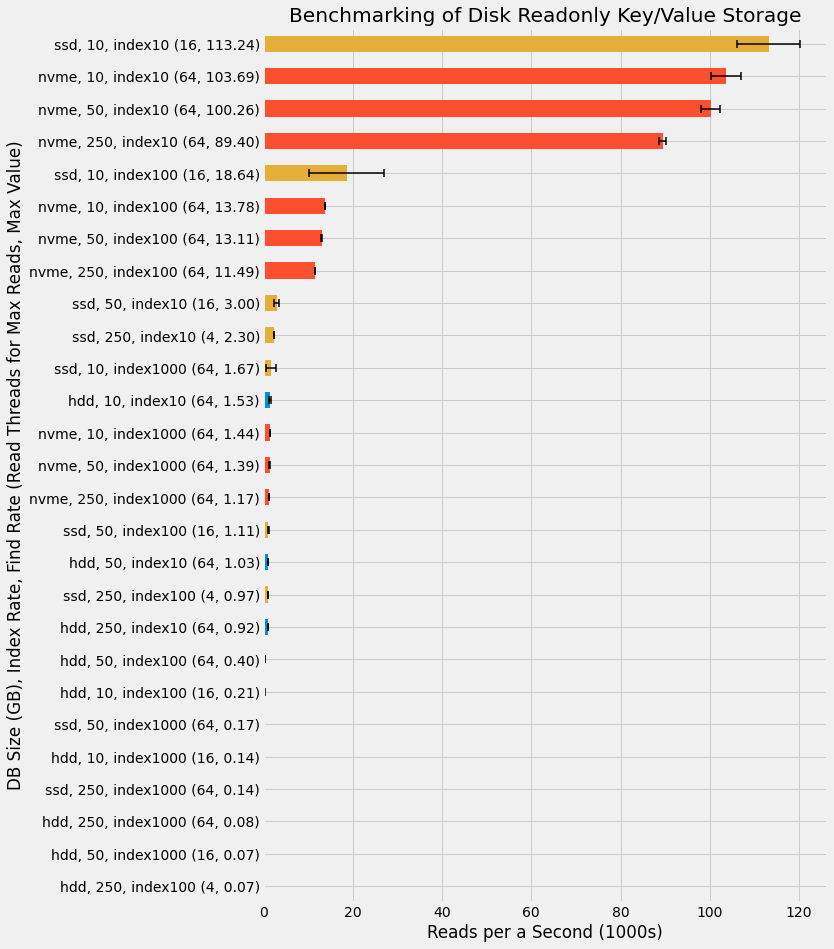

In [12]:
# compute the highest performing thread configuration for each set of parameter
def max_per(df):
    agg_ops = df.set_index('read_threads')
    idxmax = agg_ops['50%'].idxmax()
    opsmax = agg_ops.loc[idxmax]
    opsmax['read_threads'] = idxmax
    return opsmax

x = agg.reset_index()
x = x[x['known_key_get_frac'] == 0.5]
x = x[x['value_size'] == 4096]
x = (x
     .groupby(['disk', 'db_size', 'index'])
     .apply(max_per)
     .sort_values('50%', ascending=True))
iq = x[['25%', '75%']].copy()
iq['25%'] = x['50%'] - iq['25%']
iq['75%'] -= x['50%']
x.plot.barh(figsize=(9, 15), y='50%', xerr=iq.values.T,
            error_kw=dict(ecolor='black', lw=1.5, capsize=4, capthick=1.5),
            color=x.index.to_frame()['disk'].map(disk_colors))

def label(ix):
    r = x.loc[ix]
    disk, db_size, index = ix
    return f'{disk}, {db_size}, {index} ({r["read_threads"]}, {r["50%"]:.2f})'

plt.gca().set_yticklabels(map(label, x.index))
plt.gca().get_legend().remove()

plt.ylabel('DB Size (GB), Index Rate, Find Rate (Read Threads for Max Reads, Max Value)')
plt.xlabel('Reads per a Second (1000s)')
plt.title('Benchmarking of Disk Readonly Key/Value Storage')

In [ ]:
        iq = x[['25%', '75%']].copy()
        iq['25%'] = x['50%'] - iq['25%']
        iq['75%'] -= x['50%']

In [ ]:
agg['50%'].unstack()[64].sort_values().plot.barh(figsize=(7,11))

In [ ]:
((agg['75%'] - agg['25%']) / agg['50%']).describe()

In [ ]:
x = (agg['50%'].reset_index()
 .pivot_table('50%', ['index', 'db_size', 'read_threads'], 'known_key_get_frac'))
(x[0.9] / x[0.1]).sort_values().to_frame()

In [ ]:
x = agg.reset_index()
x = x[x['known_key_get_frac'] == 0.5]
x = x[x['known_key_get_frac'] == 0.5]
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1, 1, 1)
for (db_size, x),ls in zip(x.groupby('db_size'), ['-', '--', ':']):
    x = x.groupby(['index', 'read_threads'])['50%'].apply(lambda x: x.iloc[0]).unstack().T
    x.plot(ax=ax, lw=3, ms=8, marker='o', ls=ls, color=colors[:3:])
    plt.xticks([1, 4, 16, 64])
    plt.ylabel('Total Reads per a Second\n(Thousands)')
    plt.xlabel('Concurrent Reading Threads')
for l in ax.get_lines():
    if l.get_linestyle() != '-': 
        l.set_label(None)
plt.legend()

In [ ]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(hspace=0.3)
for i,(index, x) in enumerate(agg.reset_index().groupby('index')):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_title(index)
    for kkgf, x in list(x.groupby('known_key_get_frac'))[::-1]:
        x = x.set_index('read_threads')
        try:
            t0 = x['50%'].loc[1]
        except KeyError:
            continue
        for c in '25%', '50%', '75%':
            x[c] /= t0
            x[c] -= 1
            x[c] *= 100
        iq = x[['25%', '75%']].copy()
        iq['25%'] = x['50%'] - iq['25%']
        iq['75%'] -= x['50%']

        x.plot(ax=ax, y='50%', yerr=iq.values.T, label=kkgf, marker='o', ms=8, lw=3)
        ax.set_ylim(-50, 600)
        ax.set_xticks([1, 4, 16, 64])
        ax.legend(loc='upper left')